# 1. Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

import qkeras

from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize
from qkeras.utils import _add_supported_quantized_objects
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings

import math
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.datasets import mnist


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import seaborn as sns

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks, pruning_wrapper

import hls4ml
import plotting


os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

# 2. Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

train_size = x_train.shape[0]

print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {x_test.shape}, Labels: {y_test.shape}")

Training set: (60000, 28, 28, 1), Labels: (60000, 10)
Test set: (10000, 28, 28, 1), Labels: (10000, 10)


# 3. Dataset visualisation

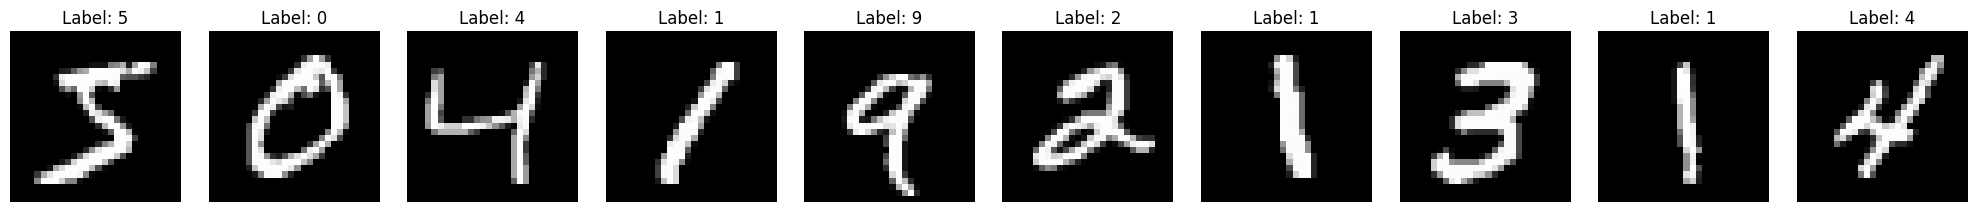

In [34]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4. Baseline Lenet 5

In [ ]:
l1_reg_weight = 0.0001

def create_lenet():
    inputs = Input(shape=(28, 28, 1), name='input_layer')

    x = layers.Conv2D(
        filters=6,
        kernel_size=5,
        kernel_initializer='lecun_uniform',
        kernel_regularizer=regularizers.l1(l1_reg_weight),
        name='conv1'
    )(inputs)
    x = layers.Activation('tanh', name='tanh1')(x)

    x = layers.AveragePooling2D(pool_size=2, strides=2, name='pool1')(x)

    x = layers.Conv2D(
        filters=16,
        kernel_size=5,
        kernel_initializer='lecun_uniform',
        kernel_regularizer=regularizers.l1(l1_reg_weight),
        name='conv2'
    )(x)
    x = layers.Activation('tanh', name='tanh2')(x)

    x = layers.AveragePooling2D(pool_size=2, strides=2, name='pool2')(x)

    x = layers.Flatten(name='flatten')(x)

    x = layers.Dense(
        units=16,
        kernel_initializer='lecun_uniform',
        kernel_regularizer=regularizers.l1(l1_reg_weight),
        name='fc1'
    )(x)
    x = layers.Activation('tanh', name='tanh3')(x)

    x = layers.Dense(
        units=16,
        kernel_initializer='lecun_uniform',
        kernel_regularizer=regularizers.l1(l1_reg_weight),
        name='fc2'
    )(x)
    x = layers.Activation('tanh', name='tanh4')(x)

    x = layers.Dense(
        units=10,
        kernel_initializer='lecun_uniform',
        kernel_regularizer=regularizers.l1(l1_reg_weight),
        name='output'
    )(x)
    outputs = layers.Activation('softmax', name='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

lenet = create_lenet()
lenet.summary()


for layer in lenet.layers:
    if isinstance(layer, (layers.Conv2D, layers.Dense)):
        weights = layer.get_weights()
        if weights:
            w = weights[0]
            layersize = np.prod(w.shape)
            print(f"{layer.name}: {layersize}")
            if layersize > 4096:
                print(f"Layer {layer.name} is too large ({layersize}), are you sure you want to train?")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 6)         156       
                                                                 
 tanh1 (Activation)          (None, 24, 24, 6)         0         
                                                                 
 pool1 (AveragePooling2D)    (None, 12, 12, 6)         0         
                                                                 
 conv2 (Conv2D)              (None, 8, 8, 16)          2416      
                                                                 
 tanh2 (Activation)          (None, 8, 8, 16)          0         
                                                                 
 pool2 (AveragePooling2D)    (None, 4, 4, 16)          0   

# 5. custom Loss for better learning

In [36]:
def sparse_categorical_crossentropy_with_l2(y_true, y_pred):
    """Custom loss combining categorical crossentropy with L2 regularization"""
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce_loss

# 6. Prune Dense and Conv layers

In [ ]:
"""# Prune dense and convolutional layers"""

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // 32
print('Number of training steps per epoch is {}'.format(NSTEPS))


def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, 
            final_sparsity=0.30, 
            begin_step=NSTEPS * 5, 
            end_step=NSTEPS * 20, 
            frequency=NSTEPS * 2
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

plenet = tf.keras.models.clone_model(lenet, clone_function=pruneFunction)

Number of training steps per epoch is 1687


# 7. Train Baseline

In [38]:
train = True
n_epochs = 10

if train:
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)

    plenet.compile(
        loss=LOSS, 
        optimizer=OPTIMIZER, 
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            verbose=1,
            restore_best_weights=True,
            min_delta=0.001,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=5,
            verbose=1,
            min_lr=1e-7
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_lenet.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            save_weights_only=False,
            mode='max'
        ),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start_time = time.time()

    history = plenet.fit(
        x=x_train,
        y=y_train,
        epochs=n_epochs,
        batch_size=32,
        shuffle=True,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        verbose=2
    )

    end_time = time.time()
    training_duration = end_time - start_time
    print(f"Training time: {training_duration / 60:.2f} minutes")


else:
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)

    plenet = tf.keras.models.load_model('best_lenet.h5', custom_objects=co)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.96630, saving model to best_lenet.h5
1875/1875 - 5s - loss: 0.4590 - accuracy: 0.9025 - top_k_categorical_accuracy: 0.9906 - val_loss: 0.1928 - val_accuracy: 0.9663 - val_top_k_categorical_accuracy: 0.9989 - lr: 0.0010 - 5s/epoch - 3ms/step
Epoch 2/10


/home2/etudiants/master2/abdennour.guessoum/.conda/envs/env_hls4ml/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.96630 to 0.97910, saving model to best_lenet.h5
1875/1875 - 4s - loss: 0.1818 - accuracy: 0.9682 - top_k_categorical_accuracy: 0.9990 - val_loss: 0.1442 - val_accuracy: 0.9791 - val_top_k_categorical_accuracy: 0.9995 - lr: 0.0010 - 4s/epoch - 2ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.97910 to 0.98160, saving model to best_lenet.h5
1875/1875 - 4s - loss: 0.1507 - accuracy: 0.9771 - top_k_categorical_accuracy: 0.9994 - val_loss: 0.1314 - val_accuracy: 0.9816 - val_top_k_categorical_accuracy: 0.9997 - lr: 0.0010 - 4s/epoch - 2ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98160 to 0.98350, saving model to best_lenet.h5
1875/1875 - 4s - loss: 0.1385 - accuracy: 0.9796 - top_k_categorical_accuracy: 0.9995 - val_loss: 0.1270 - val_accuracy: 0.9835 - val_top_k_categorical_accuracy: 0.9995 - lr: 0.0010 - 4s/epoch - 2ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.98350
1875/1875 - 4s - loss: 0.1316 - accuracy: 

# 8. Visualize training curves Baseline

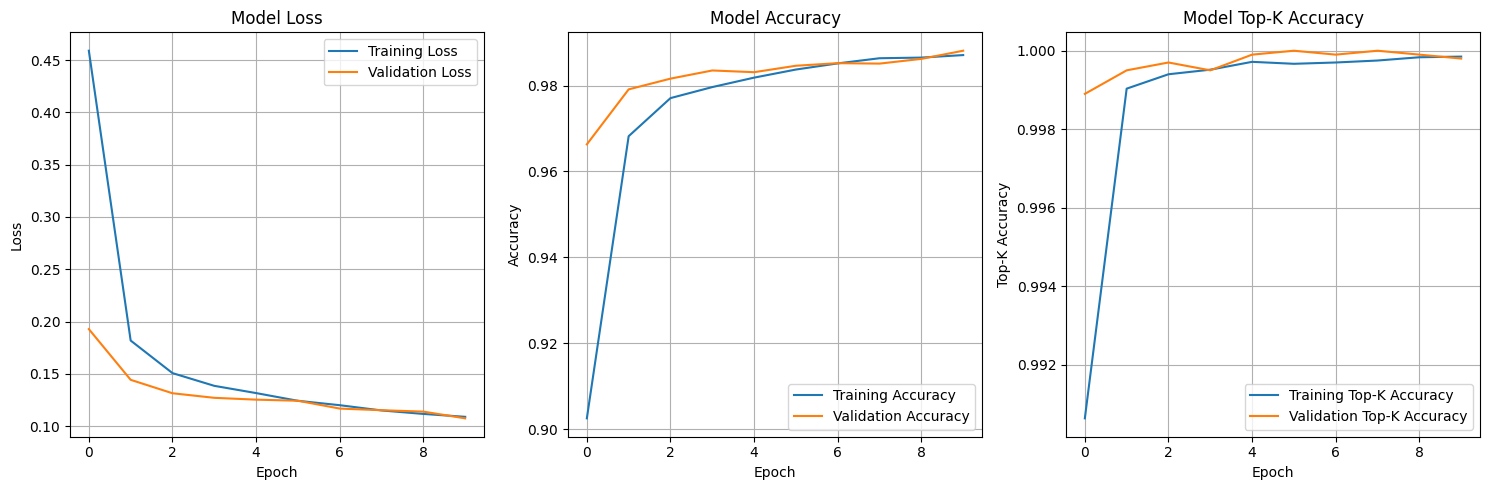

In [39]:
def plot_training_history(history):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['top_k_categorical_accuracy'], label='Training Top-K Accuracy')
    plt.plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-K Accuracy')
    plt.title('Model Top-K Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Top-K Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if train and 'history' in locals():
    plot_training_history(history)

# 9. Evaluation Baseline

Evaluating pruned LeNet model:
==== Evaluating Pruned LeNet ====
313/313 [==============================] - 0s 1ms/step
Test Accuracy: 0.9881
Test Error Rate: 0.0119
Inference time: 0.47 seconds
Average time per sample: 0.05 ms

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99 

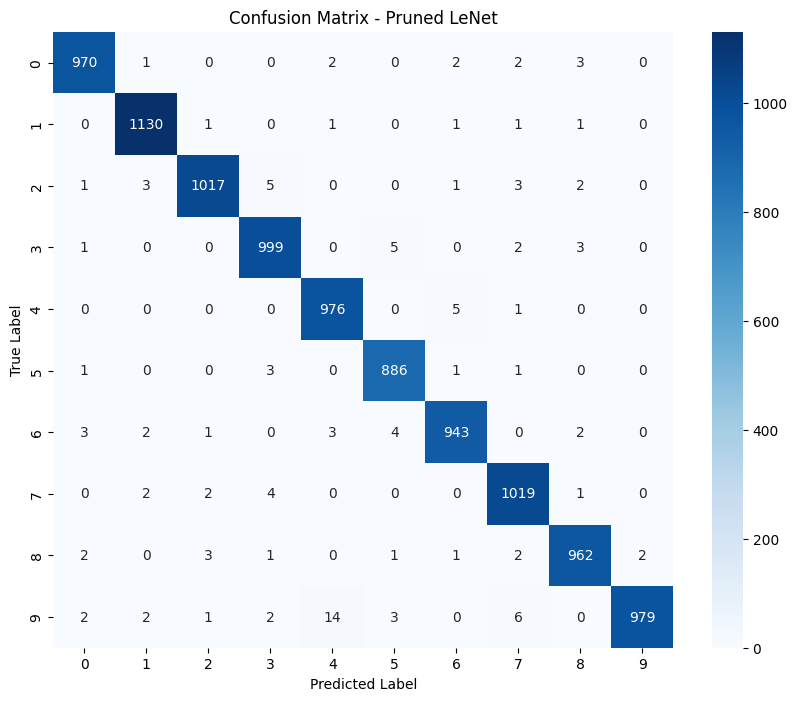

In [ ]:
def evaluate_classification(model, x_test, y_test, model_name="Model"):
    """
    Evaluate classification performance with multiple metrics
    """
    print(f"==== Evaluating {model_name} ====")
    
    start_time = time.time()
    predictions = model.predict(x_test)
    end_time = time.time()
    
    y_pred_classes = np.argmax(predictions, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Error Rate: {1-accuracy:.4f}")
    print(f"Inference time: {end_time - start_time:.2f} seconds")
    print(f"Average time per sample: {(end_time - start_time)/len(x_test)*1000:.2f} ms")
    
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))
    
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return accuracy, y_pred_classes

print("Evaluating pruned LeNet model:")
accuracy, predictions = evaluate_classification(plenet, x_test, y_test, "Pruned LeNet")

# 10. Visualize predictions

1/1 [==============================] - 0s 13ms/step


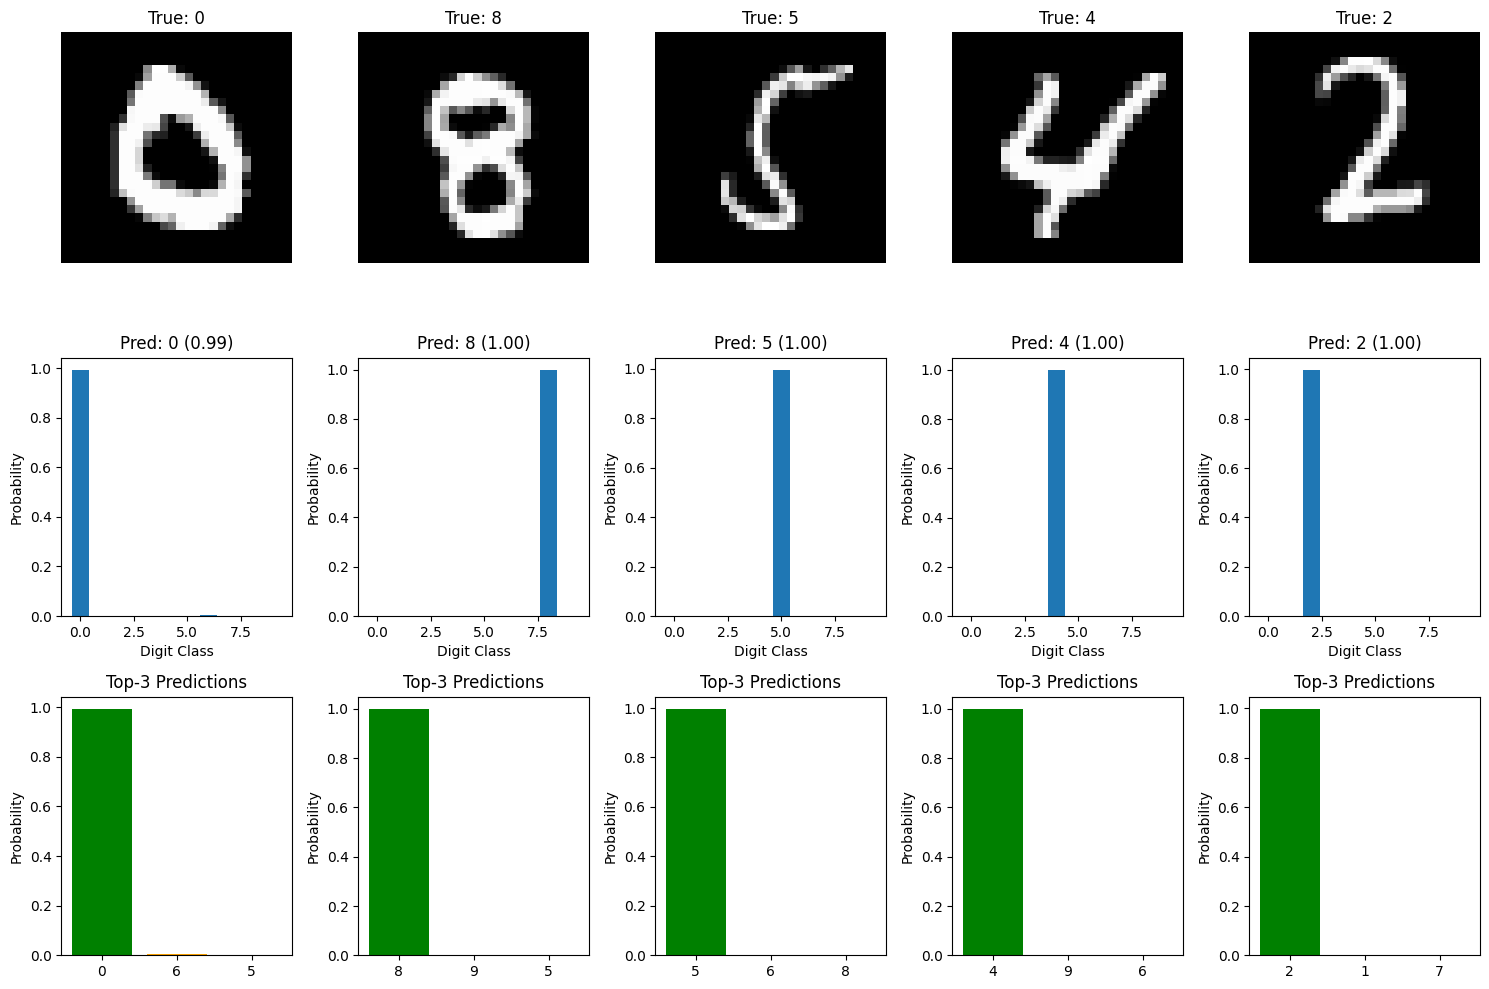

In [ ]:
n = 5
random_indices = np.random.choice(len(x_test), n, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):

    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {np.argmax(y_test[idx])}")
    plt.axis('off')
    
    ax = plt.subplot(3, n, i + 1 + n)
    pred_probs = plenet.predict(x_test[idx:idx+1])[0]
    plt.bar(range(10), pred_probs)
    plt.title(f"Pred: {np.argmax(pred_probs)} ({np.max(pred_probs):.2f})")
    plt.xlabel('Digit Class')
    plt.ylabel('Probability')
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    top3_indices = np.argsort(pred_probs)[-3:][::-1]
    top3_probs = pred_probs[top3_indices]
    colors = ['green' if idx == top3_indices[0] else 'orange' for idx in top3_indices]
    plt.bar(range(3), top3_probs, color=colors)
    plt.xticks(range(3), [str(idx) for idx in top3_indices])
    plt.title("Top-3 Predictions")
    plt.ylabel('Probability')

plt.tight_layout()
plt.show()

# 11. Quantized Lenet 5

In [ ]:
from tensorflow.keras.layers import Input, MaxPooling2D, Flatten, BatchNormalization, Activation

weight_quantizer = quantized_bits(8, 3, alpha=1)
bias_quantizer = quantized_bits(8, 3, alpha=1)
activation_quantizer = quantized_tanh(8, 3)
output_activation = 'softmax'

def create_quantized_lenet():
    inputs = Input(shape=(28, 28, 1), name='input_layer')

    x = QConv2DBatchnorm(
        filters=6,
        kernel_size=5,
        kernel_quantizer=weight_quantizer,
        bias_quantizer=bias_quantizer,
        name='qconvbn1'
    )(inputs)
    x = QActivation(activation_quantizer, name='qtanh1')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='qmaxpool1')(x)

    x = QConv2DBatchnorm(
        filters=16,
        kernel_size=5,
        kernel_quantizer=weight_quantizer,
        bias_quantizer=bias_quantizer,
        name='qconvbn2'
    )(x)
    x = QActivation(activation_quantizer, name='qtanh2')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='qmaxpool2')(x)

    x = Flatten(name='qflatten')(x)

    x = QDense(
        units=16,
        kernel_quantizer=weight_quantizer,
        bias_quantizer=bias_quantizer,
        name='qdense1'
    )(x)
    x = BatchNormalization(name='bn1')(x)
    x = QActivation(activation_quantizer, name='qtanh3')(x)

    x = QDense(
        units=16,
        kernel_quantizer=weight_quantizer,
        bias_quantizer=bias_quantizer,
        name='qdense2'
    )(x)
    x = BatchNormalization(name='bn2')(x)
    x = QActivation(activation_quantizer, name='qtanh4')(x)

    x = QDense(
        units=10,
        kernel_quantizer=weight_quantizer,
        bias_quantizer=bias_quantizer,
        name='qoutput'
    )(x)
    outputs = Activation(output_activation, name='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='conformant_qmodel')
    return model


qlenet = create_quantized_lenet()
qlenet.summary()

from qkeras.autoqkeras.utils import print_qmodel_summary
print_qmodel_summary(qlenet)

for layer in qlenet.layers:
    if isinstance(layer, (layers.Conv2D, layers.Dense, QConv2D, QDense)):
        weights = layer.get_weights()
        if weights:
            w = weights[0]
            layersize = np.prod(w.shape)
            print(f"{layer.name}: {layersize}")
            if layersize > 4096:
                print(f"Layer {layer.name} is too large ({layersize}), are you sure you want to train?")

Model: "conformant_qmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 qconvbn1 (QConv2DBatchnorm  (None, 24, 24, 6)         181       
 )                                                               
                                                                 
 qtanh1 (QActivation)        (None, 24, 24, 6)         0         
                                                                 
 qmaxpool1 (MaxPooling2D)    (None, 12, 12, 6)         0         
                                                                 
 qconvbn2 (QConv2DBatchnorm  (None, 8, 8, 16)          2481      
 )                                                               
                                                                 
 qtanh2 (QActivation)        (None, 8, 8, 16)    

In [43]:
pqlenet = tf.keras.models.clone_model(qlenet, clone_function=pruneFunction)

# 12. Train Quantized

In [44]:
train = True
n_epochs = 15
batch_size = 32
initial_lr = 1e-3

if train:
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = tf.keras.optimizers.Adam(
        learning_rate=initial_lr,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    )

    pqlenet.compile(
        loss=LOSS, 
        optimizer=OPTIMIZER, 
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            verbose=1,
            restore_best_weights=True,
            min_delta=1e-4,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            verbose=1,
            min_lr=1e-7
        ),
        pruning_callbacks.UpdatePruningStep(),
        tf.keras.callbacks.ModelCheckpoint(
            'best_pqlenet.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            save_weights_only=False,
            mode='max'
        )
    ]

    start_time = time.time()
    history = pqlenet.fit(
        x=x_train,
        y=y_train,
        epochs=n_epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        verbose=2
    )
    end_time = time.time()

    print(f"QAT + pruning training time: {(end_time - start_time) / 60:.2f} minutes")

else:
    custom_objs = _add_supported_quantized_objects({})
    custom_objs.update({
        'PruneLowMagnitude': pruning_wrapper.PruneLowMagnitude,
    })

    pqlenet = tf.keras.models.load_model(
        'best_pqlenet.h5',
        custom_objects=custom_objs
    )
    print("Quantized and pruned model loaded for inference.")

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.96100, saving model to best_pqlenet.h5
1875/1875 - 14s - loss: 0.3852 - accuracy: 0.8967 - top_k_categorical_accuracy: 0.9885 - val_loss: 0.1317 - val_accuracy: 0.9610 - val_top_k_categorical_accuracy: 0.9988 - lr: 0.0010 - 14s/epoch - 7ms/step
Epoch 2/15


/home2/etudiants/master2/abdennour.guessoum/.conda/envs/env_hls4ml/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home2/etudiants/master2/abdennour.guessoum/.conda/envs/env_hls4ml/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(



Epoch 2: val_accuracy improved from 0.96100 to 0.97390, saving model to best_pqlenet.h5
1875/1875 - 11s - loss: 0.1248 - accuracy: 0.9636 - top_k_categorical_accuracy: 0.9986 - val_loss: 0.0870 - val_accuracy: 0.9739 - val_top_k_categorical_accuracy: 0.9990 - lr: 0.0010 - 11s/epoch - 6ms/step
Epoch 3/15

Epoch 3: val_accuracy improved from 0.97390 to 0.98070, saving model to best_pqlenet.h5
1875/1875 - 11s - loss: 0.0926 - accuracy: 0.9726 - top_k_categorical_accuracy: 0.9991 - val_loss: 0.0629 - val_accuracy: 0.9807 - val_top_k_categorical_accuracy: 0.9994 - lr: 0.0010 - 11s/epoch - 6ms/step
Epoch 4/15

Epoch 4: val_accuracy improved from 0.98070 to 0.98260, saving model to best_pqlenet.h5
1875/1875 - 11s - loss: 0.0780 - accuracy: 0.9770 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.0563 - val_accuracy: 0.9826 - val_top_k_categorical_accuracy: 0.9995 - lr: 0.0010 - 11s/epoch - 6ms/step
Epoch 5/15

Epoch 5: val_accuracy improved from 0.98260 to 0.98430, saving model to best_pqle

# 13. Visualize training curves Quantized

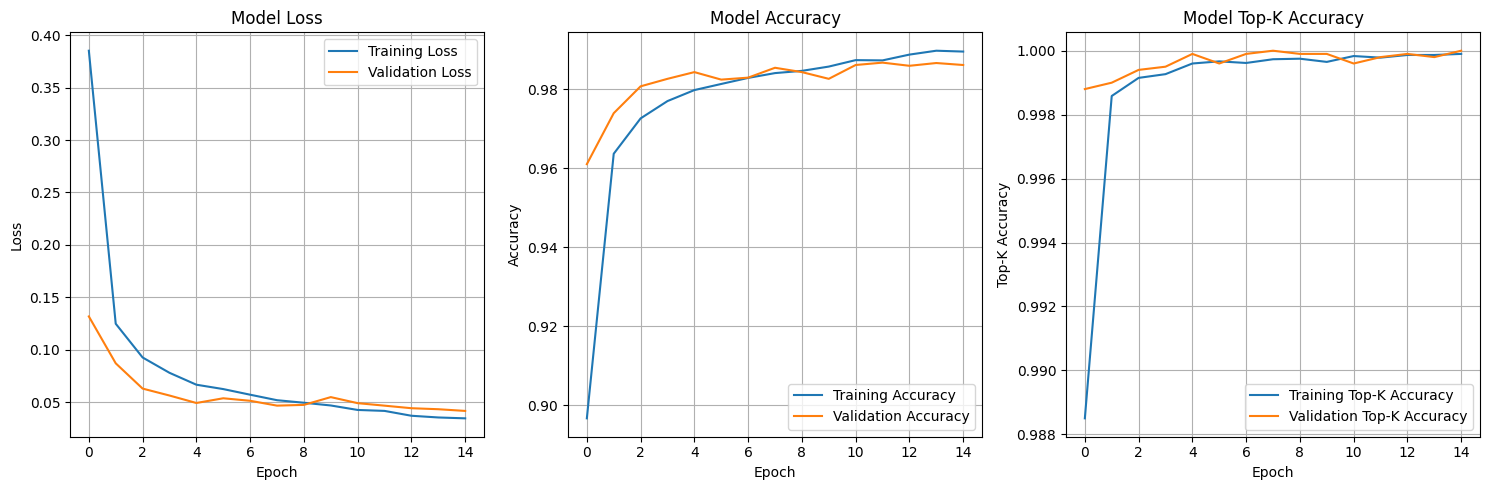

In [45]:
if train and 'history' in locals():
    plot_training_history(history)

# 14. Evaluation Quantized

Evaluating quantized pruned LeNet model:
==== Evaluating Quantized Pruned LeNet ====
313/313 [==============================] - 1s 1ms/step
Test Accuracy: 0.9861
Test Error Rate: 0.0139
Inference time: 0.65 seconds
Average time per sample: 0.07 ms

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.98      0.99      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99 

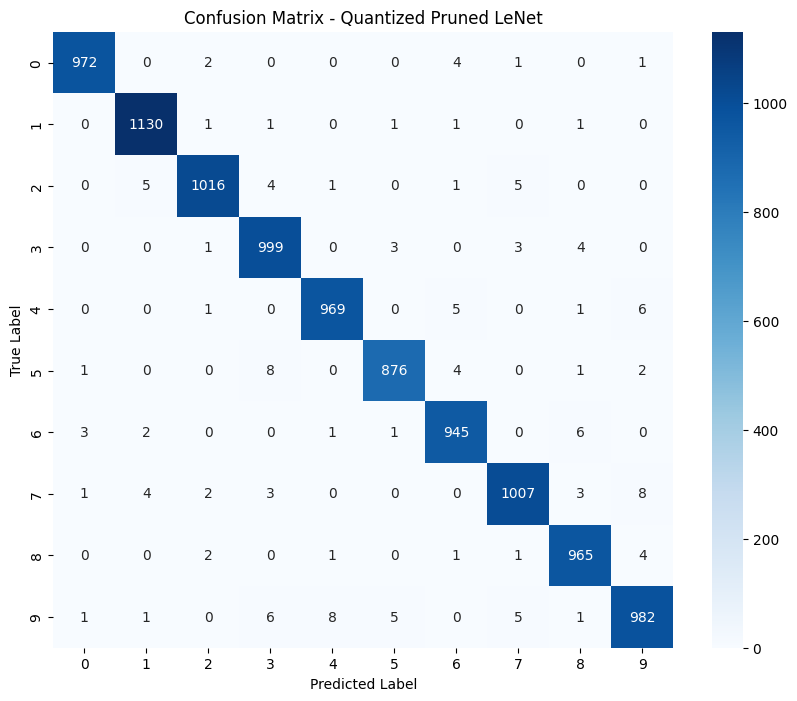

In [46]:
print("Evaluating quantized pruned LeNet model:")
accuracy_q, predictions_q = evaluate_classification(pqlenet, x_test, y_test, "Quantized Pruned LeNet")

# 14. Visualize predictions Quantized

1/1 [==============================] - 0s 12ms/step


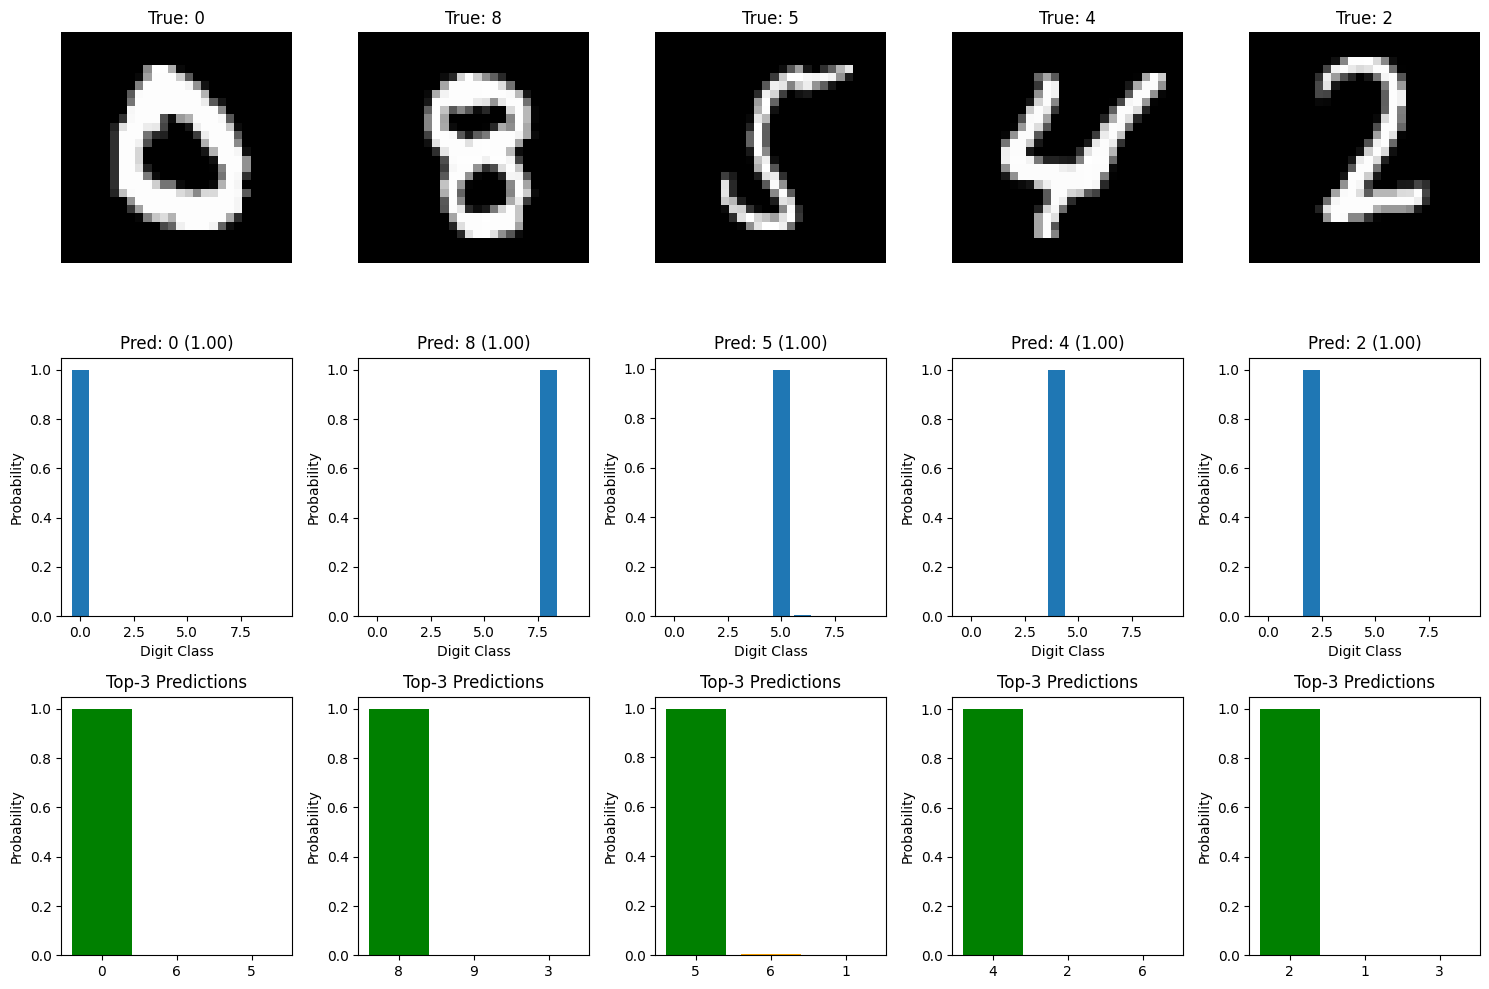

In [ ]:
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):

    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {np.argmax(y_test[idx])}")
    plt.axis('off')
    

    ax = plt.subplot(3, n, i + 1 + n)
    pred_probs = pqlenet.predict(x_test[idx:idx+1])[0]
    plt.bar(range(10), pred_probs)
    plt.title(f"Pred: {np.argmax(pred_probs)} ({np.max(pred_probs):.2f})")
    plt.xlabel('Digit Class')
    plt.ylabel('Probability')
    

    ax = plt.subplot(3, n, i + 1 + 2*n)
    top3_indices = np.argsort(pred_probs)[-3:][::-1]
    top3_probs = pred_probs[top3_indices]
    colors = ['green' if idx == top3_indices[0] else 'orange' for idx in top3_indices]
    plt.bar(range(3), top3_probs, color=colors)
    plt.xticks(range(3), [str(idx) for idx in top3_indices])
    plt.title("Top-3 Predictions")
    plt.ylabel('Probability')

plt.tight_layout()
plt.show()


# 15. Weights Prunning check

Weight analysis for pruned LeNet:
Layer prune_low_magnitude_conv1: % zeros = 0.2333
Layer prune_low_magnitude_conv2: % zeros = 0.2350
Layer prune_low_magnitude_fc1: % zeros = 0.2351
Layer prune_low_magnitude_fc2: % zeros = 0.2344
Layer output: % zeros = 0.0000


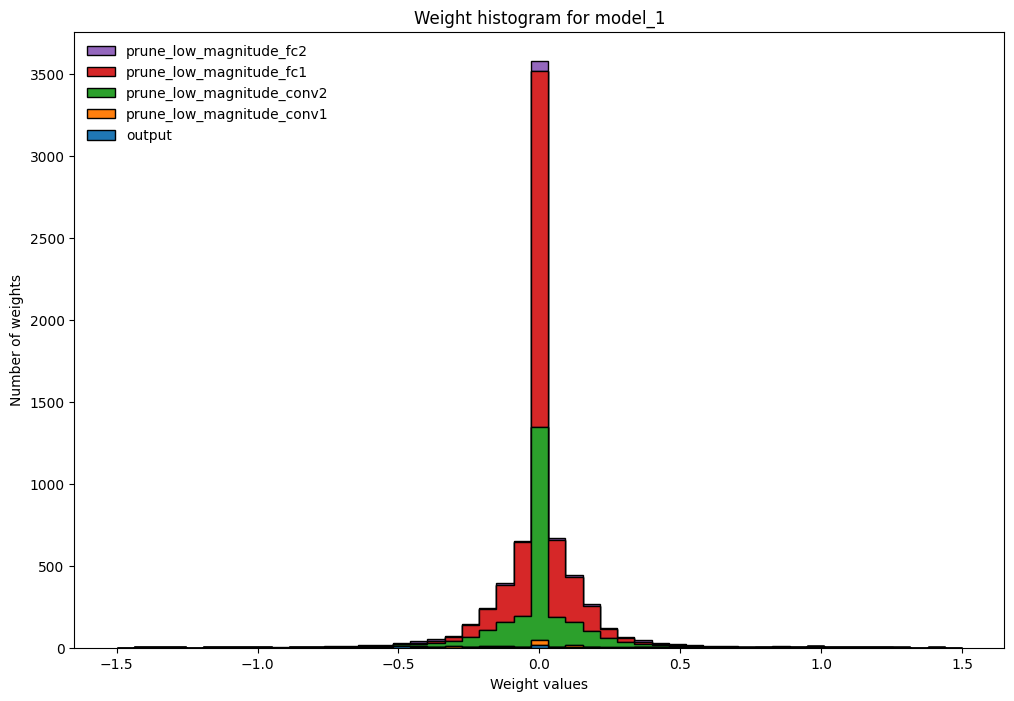


Weight analysis for quantized pruned LeNet:
Layer prune_low_magnitude_qconvbn1: % zeros = 0.2867
Layer prune_low_magnitude_qconvbn2: % zeros = 0.2888
Layer prune_low_magnitude_qdense1: % zeros = 0.2888
Layer bn1: % zeros = 0.0000
Layer prune_low_magnitude_qdense2: % zeros = 0.2891
Layer bn2: % zeros = 0.0000
Layer prune_low_magnitude_qoutput: % zeros = 0.2875


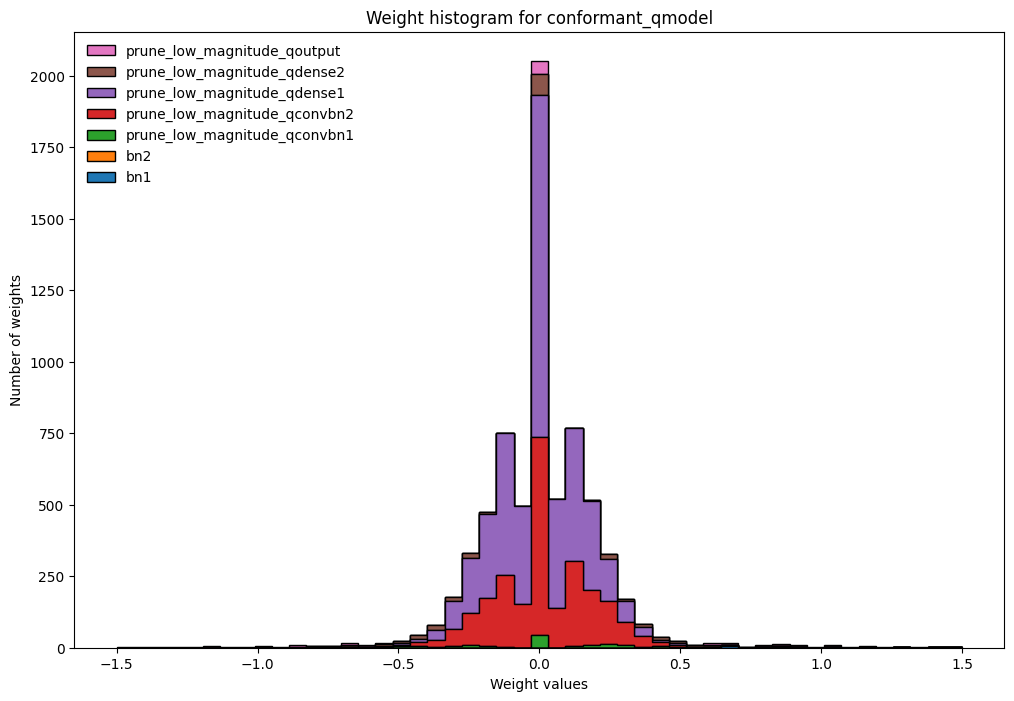

In [ ]:
def doWeights(model):
    allWeightsByLayer = {}

    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) < 1:
            continue

        kernel_weights = weights[0].flatten()
        allWeightsByLayer[layer.name] = kernel_weights

        zero_ratio = np.sum(kernel_weights == 0) / kernel_weights.size
        print(f"Layer {layer.name}: % zeros = {zero_ratio:.4f}")


    labelsW = []
    histosW = []
    for key in sorted(allWeightsByLayer.keys()):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    plt.figure(figsize=(12, 8))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of weights')
    plt.xlabel('Weight values')
    plt.title(f"Weight histogram for {model.name}")
    plt.show()

print("Weight analysis for pruned LeNet:")
doWeights(plenet)
print("\nWeight analysis for quantized pruned LeNet:")
doWeights(pqlenet)

# 16. Prepare models for HLS4ML conversion

In [49]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model('best_lenet.h5', custom_objects=co)
model = strip_pruning(model)

qmodel = tf.keras.models.load_model('best_pqlenet.h5', custom_objects=co)
qmodel = strip_pruning(qmodel)

## 16.1 Evaluation baseline + Quantized before HLS4ML conversion

### Prunned

Evaluating baseline LeNet before HLS4ML conversion:
==== Evaluating Baseline LeNet ====
313/313 [==============================] - 0s 867us/step
Test Accuracy: 0.9881
Test Error Rate: 0.0119
Inference time: 0.35 seconds
Average time per sample: 0.03 ms

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       

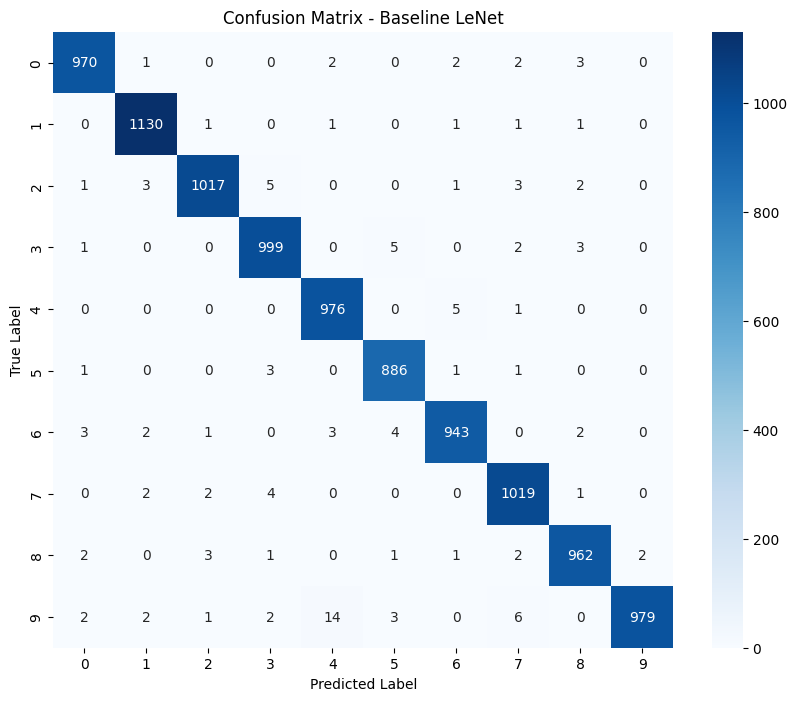

In [50]:
print("Evaluating baseline LeNet before HLS4ML conversion:")
accuracy_base, _ = evaluate_classification(model, x_test, y_test, "Baseline LeNet")

### Quantized

Evaluating quantized LeNet before HLS4ML conversion:
==== Evaluating Quantized LeNet ====
313/313 [==============================] - 1s 1ms/step
Test Accuracy: 0.9867
Test Error Rate: 0.0133
Inference time: 0.65 seconds
Average time per sample: 0.06 ms

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       

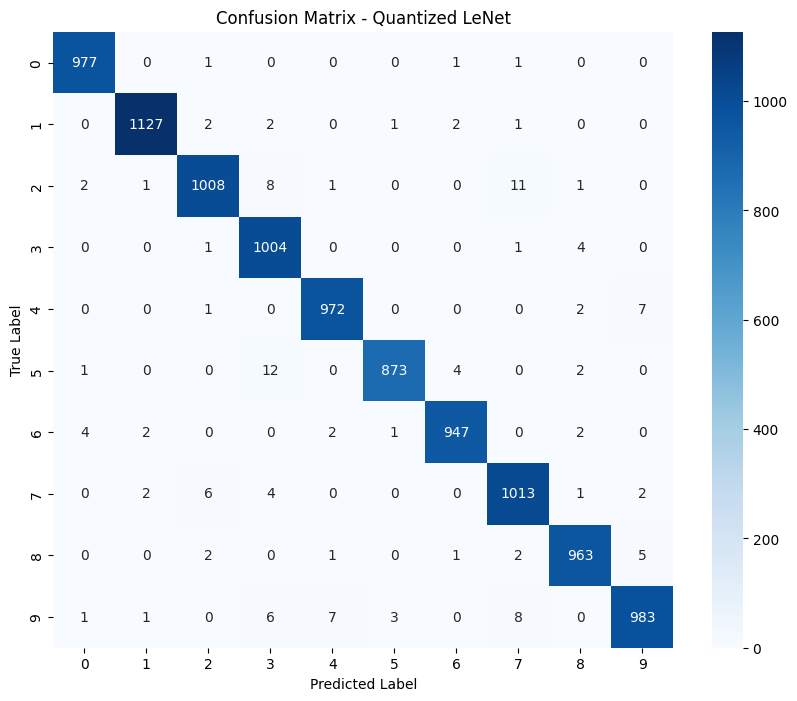

In [51]:
print("Evaluating quantized LeNet before HLS4ML conversion:")
accuracy_quant, _ = evaluate_classification(qmodel, x_test, y_test, "Quantized LeNet")

# 17. "model" configuration

# 18. Baseline synthesis

In [ ]:

test_input = x_test[:3]
test_output = model.predict(test_input)
np.save('tb_input.npy', test_input)
np.save('tb_output.npy', test_output)

1/1 [==============================] - 0s 11ms/step


In [ ]:

hls_config = hls4ml.utils.config_from_keras_model(
    model, 
    granularity='name',
    backend='Vitis'
)

Interpreting Model
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 24, 24, 6]
Layer name: tanh1, layer type: Activation, input shapes: [[None, 24, 24, 6]], output shape: [None, 24, 24, 6]
Layer name: pool1, layer type: AveragePooling2D, input shapes: [[None, 24, 24, 6]], output shape: [None, 12, 12, 6]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 12, 12, 6]], output shape: [None, 8, 8, 16]
Layer name: tanh2, layer type: Activation, input shapes: [[None, 8, 8, 16]], output shape: [None, 8, 8, 16]
Layer name: pool2, layer type: AveragePooling2D, input shapes: [[None, 8, 8, 16]], output shape: [None, 4, 4, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 4, 4, 16]], output shape: [None, 256]
Layer name: fc1, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 16]
Laye

In [ ]:

plotting.print_dict(hls_config)

Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_layer
    Trace:           False
    Precision
      result:        auto
  conv1
    Trace:           False
    Precision
      result:        auto
      weight:        auto
      bias:          auto
      accum:         auto
    ReuseFactor:     1
    ParallelizationFactor:1
    ConvImplementation:LineBuffer
  conv1_linear
    Trace:           False
    Precision
      result:        auto
      table:         fixed<18,8,TRN,WRAP,0>
    ReuseFactor:     1
    TableSize:       1024
  tanh1
    Trace:           False
    Precision
      result:        auto
      table:         fixed<18,8,TRN,WRAP,0>
    ReuseFactor:     1
    TableSize:       1024
  pool1
    Trace:           False
    Precision
      result:        auto
      accum:         auto
    ReuseFactor:     1
    ConvImplementation:LineBuffer
  conv2


In [ ]:

hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=hls_config,
    backend='Vitis',
    output_dir='Lenet5/lenet5_élagué',
    part='xczu9eg-ffvb1156-2-e',
    io_type='io_stream',
    input_data_tb='tb_input.npy',
    output_data_tb='tb_output.npy',
    clock_period=5,
)

Interpreting Model
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 24, 24, 6]
Layer name: tanh1, layer type: Activation, input shapes: [[None, 24, 24, 6]], output shape: [None, 24, 24, 6]
Layer name: pool1, layer type: AveragePooling2D, input shapes: [[None, 24, 24, 6]], output shape: [None, 12, 12, 6]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 12, 12, 6]], output shape: [None, 8, 8, 16]
Layer name: tanh2, layer type: Activation, input shapes: [[None, 8, 8, 16]], output shape: [None, 8, 8, 16]
Layer name: pool2, layer type: AveragePooling2D, input shapes: [[None, 8, 8, 16]], output shape: [None, 4, 4, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 4, 4, 16]], output shape: [None, 256]
Layer name: fc1, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 16]
Laye

In [ ]:

try:
    hls_model.compile()
    print("✅ Compilation successful!")
    

    hls_predictions = hls_model.predict(test_input)
    print("✅ Prediction test successful!")
    
except Exception as e:
    print(f"❌ Compilation failed: {e}")

Writing HLS project
Done
✅ Compilation successful!
✅ Prediction test successful!


In [ ]:

import os
import subprocess

# Path to Vitis installation
VITIS_PATH = '/tools/Xilinx/Vitis/2023.2'
SETTINGS_FILE = VITIS_PATH + '/settings64.sh'

# Source the environment in a subprocess
command = f"bash -c 'source {SETTINGS_FILE} && env'"
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
for line in proc.stdout:
    (key, _, value) = line.decode("utf-8").partition("=")
    os.environ[key] = value.strip()

proc.communicate()

# Verify vitis_hls is now found
subprocess.run(["vitis_hls", "-version"])

# Setup environment for Vitis HLS
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/gcc/x86_64-linux-gnu/12:/usr/lib/x86_64-linux-gnu'
os.environ['LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu:/usr/lib:/usr/lib32:/usr/lib/gcc/x86_64-linux-gnu/12'
os.environ['CXXFLAGS'] = '-std=c++0x'
os.environ['CFLAGS'] = ''
os.environ['LDFLAGS'] = ''


synth = False
if synth:
    start_time = time.time()
    hls_model.build(csim=True,cosim = False, synth=True, vsynth=True, reset=True)
    end_time = time.time()
    synth_duration = end_time - start_time
    print(f"Synthesis time for non quantized LeNet: {synth_duration / 60:.2f} minutes")

Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.2 (64-bit)
SW Build 4023990 on Oct 11 2023
IP Build 4028589 on Sat Oct 14 00:45:43 MDT 2023
Tool Version Limit: 2023.10
Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.
SharedData Build 4025554 on Tue Oct 10 17:18:54 MDT 2023



# 19. Quantized Synthesis

In [58]:
test_input = x_test[:3]
test_output = qmodel.predict(test_input)
np.save('tb_input.npy', test_input)
np.save('tb_output.npy', test_output)

hls_config_q = hls4ml.utils.config_from_keras_model(
    qmodel, 
    granularity='name', 
    backend='Vitis'
)

hls_config_q['Model']['ReuseFactor'] = 1
hls_config_q['Model']['Strategy'] = 'Latency'
hls_config_q['Model']['Precision'] = 'ap_fixed<8,4>'
hls_config_q['Model']['ClockPeriod'] = 5

1/1 [==============================] - 0s 12ms/step
Interpreting Model
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: qconvbn1, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 24, 24, 6]
Layer name: qtanh1, layer type: HardActivation, input shapes: [[None, 24, 24, 6]], output shape: [None, 24, 24, 6]
Layer name: qmaxpool1, layer type: MaxPooling2D, input shapes: [[None, 24, 24, 6]], output shape: [None, 12, 12, 6]
Layer name: qconvbn2, layer type: QConv2DBatchnorm, input shapes: [[None, 12, 12, 6]], output shape: [None, 8, 8, 16]
Layer name: qtanh2, layer type: HardActivation, input shapes: [[None, 8, 8, 16]], output shape: [None, 8, 8, 16]
Layer name: qmaxpool2, layer type: MaxPooling2D, input shapes: [[None, 8, 8, 16]], output shape: [None, 4, 4, 16]
Layer name: qflatten, layer type: Reshape, input shapes: [[None, 4, 4, 16]], output shape: [None, 256]
Layer

/home2/etudiants/master2/abdennour.guessoum/.conda/envs/env_hls4ml/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [59]:
plotting.print_dict(hls_config_q)

Model
  Precision:         ap_fixed<8,4>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
  ClockPeriod:       5
LayerName
  input_layer
    Trace:           False
    Precision
      result:        auto
  qconvbn1
    Trace:           False
    Precision
      result:        auto
      weight:        fixed<8,4,TRN,WRAP,0>
      bias:          fixed<8,4,TRN,WRAP,0>
      accum:         auto
    ReuseFactor:     1
    ParallelizationFactor:1
    ConvImplementation:LineBuffer
  qconvbn1_linear
    Trace:           False
    Precision
      result:        auto
      table:         fixed<18,8,TRN,WRAP,0>
    ReuseFactor:     1
    TableSize:       1024
  qtanh1
    Trace:           False
    Precision
      result:        fixed<8,1,RND_CONV,SAT,0>
      slope:         auto
      shift:         auto
      table:         fixed<18,8,TRN,WRAP,0>
    ReuseFactor:     1
    TableSize:       1024
  qmaxpool1
    Trace:           False


In [60]:
hls_model_q = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=hls_config_q,
    backend='Vitis',
    output_dir='Lenet5/lenet5_quantifié_8_4',
    part='xczu9eg-ffvb1156-2-e',
    io_type='io_stream',
    input_data_tb='tb_input.npy',
    output_data_tb='tb_output.npy',
    clock_period=5,
)

Interpreting Model
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: qconvbn1, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 24, 24, 6]
Layer name: qtanh1, layer type: HardActivation, input shapes: [[None, 24, 24, 6]], output shape: [None, 24, 24, 6]
Layer name: qmaxpool1, layer type: MaxPooling2D, input shapes: [[None, 24, 24, 6]], output shape: [None, 12, 12, 6]
Layer name: qconvbn2, layer type: QConv2DBatchnorm, input shapes: [[None, 12, 12, 6]], output shape: [None, 8, 8, 16]
Layer name: qtanh2, layer type: HardActivation, input shapes: [[None, 8, 8, 16]], output shape: [None, 8, 8, 16]
Layer name: qmaxpool2, layer type: MaxPooling2D, input shapes: [[None, 8, 8, 16]], output shape: [None, 4, 4, 16]
Layer name: qflatten, layer type: Reshape, input shapes: [[None, 4, 4, 16]], output shape: [None, 256]
Layer name: qdense1, layer type: QDense, input shapes: [[

In [ ]:

try:
    hls_model_q.compile()
    print("✅ Compilation successful!")
    

    hls_predictions = hls_model.predict(test_input)
    print("✅ Prediction test successful!")
    
except Exception as e:
    print(f"❌ Compilation failed: {e}")

Writing HLS project
Done
✅ Compilation successful!
✅ Prediction test successful!


In [62]:
synth = True
if synth:
    start_time = time.time()
    hls_model_q.build(csim=True,cosim = False, synth=True, vsynth=False, reset=True)
    end_time = time.time()
    synth_duration = end_time - start_time
    print(f"Synthesis time for quantized LeNet: {synth_duration / 60:.2f} minutes")


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.2 (64-bit)
  **** SW Build 4023990 on Oct 11 2023
  **** IP Build 4028589 on Sat Oct 14 00:45:43 MDT 2023
  **** SharedData Build 4025554 on Tue Oct 10 17:18:54 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis_HLS/2023.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vitis_HLS/2023.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'abdennour.guessoum' on host '23hp049.univ-brest.fr' (Linux_x86_64 version 6.1.0-18-amd64) on Mon Nov 03 17:24:21 CET 2025
INFO: [HLS 200-10] On os Debian GNU/Linux 12 (bookworm)
INFO: [HLS 200-10] In directory '/home2/etudiants/master2/abdennour.guessoum/Téléchargements/M2/Projet_M2/hls4ml-tutorial/Lenet5/lenet5_quantifié_8_4'
INFO: [HLS 200-2053] The vitis_hls executable is being deprecated. Consider using vitis-run --mode

INFO: [HLS 200-111] Finished Source Code Analysis and Preprocessing: CPU user time: 7.73 seconds. CPU system time: 0.51 seconds. Elapsed time: 8.6 seconds; current allocated memory: 271.277 MB.
INFO: [HLS 200-777] Using interface defaults for 'Vivado' flow target.
INFO: [HLS 200-1995] There were 18,749 instructions in the design after the 'Compile/Link' phase of compilation. See the Design Size Report for more details: /home2/etudiants/master2/abdennour.guessoum/Téléchargements/M2/Projet_M2/hls4ml-tutorial/Lenet5/lenet5_quantifié_8_4/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 84,596 instructions in the design after the 'Array/Struct (step 1)' phase of compilation. See the Design Size Report for more details: /home2/etudiants/master2/abdennour.guessoum/Téléchargements/M2/Projet_M2/hls4ml-tutorial/Lenet5/lenet5_quantifié_8_4/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 47,566 instructions in the d

INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_latency<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config15>(ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>*, ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>*, config15::weight_t*, config15::bias_t*)' (firmware/nnet_utils/nnet_dense_latency.h:42:27)
INFO: [HLS 214-131] Inlining function 'nnet::array<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[](unsigned long) (.10)' into 'void nnet::res_write<nnet::array<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config15>(nnet::array<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::value_type*, hls::stream<nnet::array<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, 0>&) (.8)' (fir

INFO: [HLS 214-186] Unrolling loop 'SoftmaxInvPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:241:9) in function 'nnet::softmax_stable<nnet::array<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config21>' completely with a factor of 10 (firmware/nnet_utils/nnet_activation_stream.h:170:0)
INFO: [HLS 214-186] Unrolling loop 'ResPackSingle' (firmware/nnet_utils/nnet_dense_stream.h:73:9) in function 'nnet::dense<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, config19>' completely with a factor of 10 (firmware/nnet_utils/nnet_dense_stream.h:84:0)
INFO: [HLS 214-186] Unrolling loop 'DataPackSingle' (firmware/nnet_utils/nnet_dense_stream.h:45:9) in function 'nnet::dense<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, config19>' completely 

INFO: [HLS 214-186] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:192:9) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, config9>' completely with a factor of 2 (firmware/nnet_utils/nnet_conv_stream.h:219:0)
INFO: [HLS 214-186] Unrolling loop 'KernelShiftChannel' (firmware/nnet_utils/nnet_conv_stream.h:194:13) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, config9>' completely with a factor of 16 (firmware/nnet_utils/nnet_conv_stream.h:219:0)
INFO: [HLS 214-186] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:236:5) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, config9>' completely with a factor of 16 (firmware/nnet_utils/nnet_conv_stream.h:219:0)
INFO: [HLS 214-186] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:239:9) in function 'nnet::shift

INFO: [HLS 214-186] Unrolling loop 'KernelShiftChannel' (firmware/nnet_utils/nnet_conv_stream.h:194:13) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 6u>, config5>' completely with a factor of 6 (firmware/nnet_utils/nnet_conv_stream.h:219:0)
INFO: [HLS 214-186] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:236:5) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 6u>, config5>' completely with a factor of 6 (firmware/nnet_utils/nnet_conv_stream.h:219:0)
INFO: [HLS 214-186] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:239:9) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 6u>, config5>' completely with a factor of 1 (firmware/nnet_utils/nnet_conv_stream.h:219:0)
INFO: [HLS 214-186] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:228:5) in function 'nnet::shift_line_buff

INFO: [HLS 214-178] Inlining function 'nnet::array<ap_fixed<25, 14, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[](unsigned long)' into 'void nnet::compute_output_buffer_2d<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 6u>, nnet::array<ap_fixed<25, 14, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>(nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 6u> const&, ap_shift_reg<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 6u>::value_type, config6::in_width> (*) [config6::n_chan], hls::stream<nnet::array<ap_fixed<25, 14, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, 0>&, config6::weight_t*, config6::bias_t*)' (firmware/nnet_utils/nnet_conv_stream.h:257:0)
INFO: [HLS 214-178] Inlining function 'nnet::array<ap_fixed<25, 14, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[](unsigned long)' into 'void nnet::hard_tanh<nnet::array<ap_fixed<25, 14, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, hard_tanh_config8>(hl

INFO: [HLS 214-178] Inlining function 'ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 2, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >(ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> const*, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> >) (.187)' into 'ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 10, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >(ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> const*, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> >)' (firmware/nnet_utils/nnet_common.h:37:0)
INFO: [HLS 214-178] Inlining function 'nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> >::operator()(ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>) (.160.169)' into 'ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (

INFO: [HLS 214-241] Aggregating bram variable '_ZZN4nnet25conv_2d_buffer_latency_clINS_5arrayI8ap_fixedILi8ELi1EL9ap_q_mode4EL9ap_o_mode0ELi0EELj6EEENS1_IS2_ILi25ELi14ELS3_5ELS4_3ELi0EELj16EEE7config6EEvRN3hls6streamIT_Li0EEERNSB_IT0_Li0EEEPNT1_8weight_tEPNSI_6bias_tEE11line_buffer_1_5' with compact=bit mode in 8-bits
INFO: [HLS 214-241] Aggregating bram variable '_ZZN4nnet25conv_2d_buffer_latency_clINS_5arrayI8ap_fixedILi8ELi1EL9ap_q_mode4EL9ap_o_mode0ELi0EELj6EEENS1_IS2_ILi25ELi14ELS3_5ELS4_3ELi0EELj16EEE7config6EEvRN3hls6streamIT_Li0EEERNSB_IT0_Li0EEEPNT1_8weight_tEPNSI_6bias_tEE11line_buffer_2_0' with compact=bit mode in 8-bits
INFO: [HLS 214-241] Aggregating bram variable '_ZZN4nnet25conv_2d_buffer_latency_clINS_5arrayI8ap_fixedILi8ELi1EL9ap_q_mode4EL9ap_o_mode0ELi0EELj6EEENS1_IS2_ILi25ELi14ELS3_5ELS4_3ELi0EELj16EEE7config6EEvRN3hls6streamIT_Li0EEERNSB_IT0_Li0EEEPNT1_8weight_tEPNSI_6bias_tEE11line_buffer_2_1' with compact=bit mode in 8-bits
INFO: [HLS 214-241] Aggregating bram var

INFO: [HLS 200-111] Finished Compiling Optimization and Transform: CPU user time: 82.61 seconds. CPU system time: 0.68 seconds. Elapsed time: 87.35 seconds; current allocated memory: 290.879 MB.
INFO: [HLS 200-111] Finished Checking Pragmas: CPU user time: 0 seconds. CPU system time: 0 seconds. Elapsed time: 0 seconds; current allocated memory: 290.879 MB.
INFO: [HLS 200-10] Starting code transformations ...
INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 0.89 seconds. CPU system time: 0.02 seconds. Elapsed time: 1.01 seconds; current allocated memory: 317.105 MB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 10, nnet::Op_max<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::softmax_stable<nnet::array<ap_fixed<21, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config21>' (firmware/nn

INFO: [HLS 200-111] Finished Loop, function and other optimizations: CPU user time: 4.78 seconds. CPU system time: 0.05 seconds. Elapsed time: 5 seconds; current allocated memory: 408.344 MB.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:109:5) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 6u>, nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 6u>, config5>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:109:5) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<8, 1, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, config9>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_conv2d_stream.h:24:5) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<22, 14, (ap_

INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed<8, 4, 5, 3, 0>, ap_fixed<22, 14, 5, 3, 0>, config2_mult>'.
INFO: [HLS 200-1470] Pipelining result : Target II = 1, Final II = 1, Depth = 2, function 'dense_latency<ap_fixed<8, 4, 5, 3, 0>, ap_fixed<22, 14, 5, 3, 0>, config2_mult>'
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.19 seconds. CPU system time: 0 seconds. Elapsed time: 0.24 seconds; current allocated memory: 760.230 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.05 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.12 seconds; current allocated memory: 760.980 MB.
INFO: [HLS 200-10]

INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.06 seconds. CPU system time: 0 seconds. Elapsed time: 0.11 seconds; current allocated memory: 767.160 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.03 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.07 seconds; current allocated memory: 767.309 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_6u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'shift_line_buffer<array<ap_fixed<8, 1, 4, 0, 0>, 

INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.03 seconds. CPU system time: 0 seconds. Elapsed time: 0.08 seconds; current allocated memory: 808.664 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'hard_tanh_array_array_ap_fixed_8_1_4_0_0_16u_hard_tanh_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'HardSigmoidActLoop'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 4, loop 'HardSigmoidActLoop'
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.17 seconds. CPU system time: 0.01 seconds. Ela

INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.12 seconds. CPU system time: 0 seconds. Elapsed time: 0.16 seconds; current allocated memory: 896.273 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.06 seconds. CPU system time: 0 seconds. Elapsed time: 0.12 seconds; current allocated memory: 896.273 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_wrapper_ap_fixed_ap_fixed_21_10_5_3_0_config15_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...


INFO: [HLS 200-42] -- Implementing module 'softmax_array_array_ap_fixed_8_4_5_3_0_10u_softmax_config21_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.04 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.11 seconds; current allocated memory: 913.453 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.02 seconds. CPU system time: 0 seconds. Elapsed time: 0.07 seconds; current allocated memory: 913.453 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module '

INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'compute_output_buffer_2d_array_array_ap_fixed_22_14_5_3_0_6u_config2_s' pipeline 'compute_output_buffer_2d<array,array<ap_fixed<22,14,5,3,0>,6u>,config2>' pipeline type 'function pipeline'
INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_22_14_5_3_0_6u_config2_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 0.2 seconds. CPU system time: 0.03 seconds. Elapsed time: 0.52 seconds; current allocated memory: 928.598 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_1u_array_ap_fixed_22_14_5_3_0_6u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'conv_2d_cl_array_ap_fixed_1u_array_ap_fixed_22_14_5_3_0_6u_config2_s' pipeline 'ReadInputHeight

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_6u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_6u_config6_s_p_ZZN4nnet25conv_2d_buffer_latency_clINS_5arrayI8ap_fixedILi8ELi1EL9ap_q_mode4EL9_23_SHIFTREG_AUTO_0R0W' to 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_6u_config6_s_p_ZZN4nnet25conv_2d_blbW' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_6u_config6_s_p_ZZN4nnet25conv_2d_buffer_latency_clINS_5arrayI8ap_fixedILi8ELi1EL9ap_q_mode4EL9_17_SHIFTREG_AUTO_0R0W' to 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_6u_config6_s_p_ZZN4nnet25conv_2d_bmb6' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_6u_config6_

INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_ap_fixed_8_1_4_0_0_ap_fixed_25_14_5_3_0_config6_mult_s' is 5360 from HDL expression: (1'b0 == ap_block_pp0_stage0)
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_ap_fixed_8_1_4_0_0_ap_fixed_25_14_5_3_0_config6_mult_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 0.86 seconds. CPU system time: 0.02 seconds. Elapsed time: 1.01 seconds; current allocated memory: 983.578 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_25_14_5_3_0_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------


INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'compute_output_buffer_2d_array_array_ap_fixed_25_14_5_3_0_16u_config6_s' pipeline 'compute_output_buffer_2d<array,array<ap_fixed<25,14,5,3,0>,16u>,config6>' pipeline type 'function pipeline'
INFO: [RTGEN 206-104] Estimated max fanout for 'compute_output_buffer_2d_array_array_ap_fixed_25_14_5_3_0_16u_config6_s' is 7110 from HDL expression: ((1'b1 == ap_ce) & (((1'b0 == ap_block_pp0_stage5_11001_ignoreCallOp57) & (1'b1 == ap_CS_fsm_pp0_stage5)) | ((1'b0 == ap_block_pp0_stage4_11001_ignoreCallOp56) & (1'b1 == ap_CS_fsm_pp0_stage4)) | ((1'b0 == ap_block_pp0_stage3_11001_ignoreCallOp55) & (1'b1 == ap_CS_fsm_pp0_stage3)) | ((1'b0 == ap_block_pp0_stage2_11001_ignoreCallOp51) & (1'b1 == ap_CS_fsm_pp0_stage2)) | ((1'b0 == ap_block_pp0_stage1_11001_ignoreCallOp30) & (1'b1 == ap_CS_fsm_pp0_stage1))))
INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_25_14_5_3_0_16u_config6_s'.
INFO: [

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_16u_config9_s_p_ZZN4nnet12pooling2d_clINS_5arrayI8ap_fixedILi8ELi1EL9ap_q_mode4EL9ap_o_mode0ELi_1_SHIFTREG_AUTO_0R0W' to 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_16u_config9_s_p_ZZN4nnet12pooling2Xh4' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_16u_config9_s_p_ZZN4nnet12pooling2d_clINS_5arrayI8ap_fixedILi8ELi1EL9ap_q_mode4EL9ap_o_mode0ELi_SHIFTREG_AUTO_0R0W' to 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_16u_config9_s_p_ZZN4nnet12pooling2Yie' due to the length limit 80
INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_ap_fixed_8_1_4_0_0_16u_config9_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 0.24 seconds. CPU system time: 0.02 seconds. Elapsed time: 0.55 seconds; current allocated memory: 1.068 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
I

INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'pooling2d_cl_array_ap_fixed_16u_array_ap_fixed_8_1_4_0_0_16u_config9_s' pipeline 'ReadInputHeight_ReadInputWidth' pipeline type 'loop pipeline'
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_ap_fixed_16u_array_ap_fixed_8_1_4_0_0_16u_config9_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 0.4 seconds. CPU system time: 0.05 seconds. Elapsed time: 1 seconds; current allocated memory: 1.082 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_25_14_5_3_0_16u_config11_Pipeline_DataPrepare' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'dense_array_array_ap_fixed_25_14_5_3_0_16u_config11_Pipeline_DataPrepare' pipeline 'DataPrepare' pipeline type 'loop pipeline'
INFO: [RTGEN 2

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_wrapper_ap_fixed_ap_fixed_21_10_5_3_0_config19_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'mul_8s_5ns_13_1_0': 7 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_8s_5s_13_1_0': 7 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_8s_6ns_13_1_1': 2 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_8s_6ns_14_1_0': 6 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_8s_6s_13_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_8s_6s_14_1_0': 9 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_wrapper_ap_fixed_ap_fixed_21_10_5_3_0_config19_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 0.25 seconds. CPU system time: 0.03 seconds. Elapse

INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 0.28 seconds. CPU system time: 0.03 seconds. Elapsed time: 0.78 seconds; current allocated memory: 1.419 GB.
INFO: [HLS 200-111] Finished Generating all RTL models: CPU user time: 0.57 seconds. CPU system time: 0.07 seconds. Elapsed time: 2.17 seconds; current allocated memory: 1.421 GB.
INFO: [HLS 200-111] Finished Updating report files: CPU user time: 1.74 seconds. CPU system time: 0.07 seconds. Elapsed time: 1.95 seconds; current allocated memory: 1.463 GB.
INFO: [VHDL 208-304] Generating VHDL RTL for myproject.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject.
INFO: [HLS 200-790] **** Loop Constraint Status: All loop constraints were NOT satisfied.
INFO: [HLS 200-789] **** Estimated Fmax: 274.24 MHz
INFO: [HLS 200-111] Finished Command csynth_design CPU user time: 128.96 seconds. CPU system time: 2.66 seconds. Elapsed time: 151.24 seconds; current allocated memory: 1.207 GB.
***** C/RTL SYNTHESIS COMPLETED IN 